In [58]:
import sys
sys.path.append("/home/jovyan/work/robosat.pink/")

from robosat_pink.datasets import *
from robosat_pink.tiles import *

from sklearn.model_selection import train_test_split

from robosat_pink.models import albunet
from robosat_pink.tools.train import train
from robosat_pink.losses.lovasz import Lovasz
import robosat_pink

import albumentations as A

from numpy.random import choice

from tqdm import tqdm

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader

from os import environ
environ['CURL_CA_BUNDLE']='/etc/ssl/certs/ca-certificates.crt'

from imp import reload
reload(robosat_pink.losses.lovasz)
from robosat_pink.losses.lovasz import Lovasz


import matplotlib.pyplot as plt
%matplotlib inline

# Test Training

In [6]:
DATA_DIR = "s3://planet-snowcover-imagery/20180601_181450_0f32_3B_AnalyticMS_SR_clip_tiled"
MASK_DIR = "s3://planet-snowcover-snow/ASO_3M_SD_USCASJ_20180601_tiles_02"
all_tiles = SlippyMapTilesConcatenation(path = DATA_DIR, 
                                        target = MASK_DIR, 
                                        aws_profile = 'esip')

In [7]:
train_ids, test_ids = train_test_split(all_tiles.tiles)

In [8]:
train_ids_idx = choice(range(0, len(train_ids)), 50)
test_ids_idx = choice(range(0, len(test_ids)), 10)
train_ids = [train_ids[i] for i in train_ids_idx]
test_ids =  [test_ids[i] for i in test_ids_idx]

In [9]:
transform = A.Compose([
    #A.ToFloat(p = 1),
    # A.RandomRotate90(p = 0.5),
    #A.RandomRotate90(p = 0.5),
    #A.RandomRotate90(p = 0.5), #these do something bad to the bands
#    A.Normalize(mean = mean, std = std, max_pixel_value = 1),
    A.HorizontalFlip(p = 0.5),
    A.VerticalFlip(p = 0.5),
#    A.ToFloat(p = 1, max_value = np.finfo(np.float64).max)
])

train_tiles = SlippyMapTilesConcatenation(path = DATA_DIR, 
                                          target = MASK_DIR, 
                                          tiles = train_ids,
                                          aws_profile = 'esip')#,
#                                           joint_transform = transform)
valid_tiles = SlippyMapTilesConcatenation(path = DATA_DIR, 
                                          target = MASK_DIR, 
                                          tiles = test_ids, 
                                          aws_profile = 'esip')#, 
#                                           joint_transform = transform)

42
10


---
Some Neural Network Infrastrcuture

In [14]:
net = albunet.Albunet(num_classes = 1, num_channels = 4)
device = torch.device('cpu')
#net = torch.nn.DataParallel(net)

In [15]:
train_loader = DataLoader(train_tiles,
                          batch_size = 5,
                          shuffle  = True,
                          drop_last=True, 
                          num_workers = 0)

In [16]:
valid_loader = DataLoader(valid_tiles,
                          batch_size = 5,
                          shuffle  = True,
                          drop_last=True, 
                          num_workers = 0)

In [64]:
criterion = Lovasz().to(device)
optimizer = Adam(net.parameters(), lr=0.001)

In [ ]:

train_hist = train(train_loader, 1, device, net, optimizer, criterion)


Train:   0%|          | 0/8 [00:00<?, ?batch/s]

tensor([[[[0.6344, 0.6370, 0.6402,  ..., 0.1796, 0.1607, 0.1499],
          [0.6352, 0.6371, 0.6395,  ..., 0.1835, 0.1616, 0.1489],
          [0.6375, 0.6382, 0.6391,  ..., 0.1891, 0.1639, 0.1489],
          ...,
          [0.1360, 0.1354, 0.1334,  ..., 0.0932, 0.0863, 0.0823],
          [0.1459, 0.1424, 0.1370,  ..., 0.1039, 0.0916, 0.0843],
          [0.1536, 0.1477, 0.1393,  ..., 0.1118, 0.0956, 0.0856]],

         [[0.4613, 0.4619, 0.4626,  ..., 0.2021, 0.1850, 0.1752],
          [0.4615, 0.4619, 0.4623,  ..., 0.2077, 0.1896, 0.1793],
          [0.4623, 0.4624, 0.4623,  ..., 0.2155, 0.1963, 0.1852],
          ...,
          [0.1645, 0.1571, 0.1475,  ..., 0.1072, 0.1004, 0.0964],
          [0.1781, 0.1680, 0.1548,  ..., 0.1157, 0.1053, 0.0992],
          [0.1886, 0.1764, 0.1603,  ..., 0.1218, 0.1088, 0.1011]],

         [[0.6877, 0.6906, 0.6946,  ..., 0.2062, 0.1930, 0.1859],
          [0.6887, 0.6913, 0.6948,  ..., 0.2132, 0.1991, 0.1916],
          [0.6902, 0.6925, 0.6956,  ..., 0

Train:  12%|#2        | 1/8 [00:41<04:51, 41.59s/batch]

tensor([[[[0.0852, 0.0863, 0.0878,  ..., 0.0688, 0.0661, 0.0645],
          [0.0876, 0.0883, 0.0893,  ..., 0.0672, 0.0656, 0.0648],
          [0.0903, 0.0906, 0.0909,  ..., 0.0648, 0.0648, 0.0653],
          ...,
          [0.0460, 0.0481, 0.0507,  ..., 0.0618, 0.0616, 0.0613],
          [0.0441, 0.0464, 0.0494,  ..., 0.0613, 0.0624, 0.0630],
          [0.0428, 0.0451, 0.0483,  ..., 0.0612, 0.0633, 0.0646]],

         [[0.1037, 0.1042, 0.1048,  ..., 0.0826, 0.0797, 0.0778],
          [0.1051, 0.1054, 0.1057,  ..., 0.0818, 0.0798, 0.0787],
          [0.1065, 0.1065, 0.1066,  ..., 0.0807, 0.0801, 0.0800],
          ...,
          [0.0637, 0.0651, 0.0667,  ..., 0.0800, 0.0802, 0.0801],
          [0.0617, 0.0635, 0.0657,  ..., 0.0790, 0.0802, 0.0809],
          [0.0604, 0.0623, 0.0649,  ..., 0.0784, 0.0803, 0.0816]],

         [[0.1261, 0.1275, 0.1292,  ..., 0.0960, 0.0937, 0.0924],
          [0.1278, 0.1287, 0.1298,  ..., 0.0948, 0.0932, 0.0924],
          [0.1294, 0.1298, 0.1302,  ..., 0

Lovasz()

In [17]:
s = None
for i in train_loader:
    s = i
    break 

In [ ]:
images, masks, tiles = s

In [19]:
images.size()[2:], masks.squeeze().shape

(torch.Size([512, 512]), torch.Size([5, 512, 512]))

In [20]:
o = net(s[0].float())

In [36]:
o.size()[1]

1

In [62]:
reload(robosat_pink.losses.lovasz)
from robosat_pink.losses.lovasz import Lovasz

criterion = Lovasz()

In [63]:
criterion(o, masks)

torch.Size([5, 1, 512, 512]) torch.float32


tensor(1.0245, grad_fn=<DivBackward0>)

In [57]:
N, C, H, W = o.size()
torch.zeros(N, C, H, W).to(masks.device).scatter_(1, masks.view(N, 1, H, W), 1)

RuntimeError: Invalid index in scatter at /pytorch/aten/src/TH/generic/THTensorEvenMoreMath.cpp:549

In [38]:
o.size()[1] == 1

True

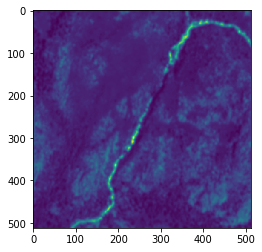

In [31]:
plt.imshow(s[0][1, 1, :, :].detach().numpy())

In [37]:
s[0]

[tensor([[[[0.0651, 0.0655, 0.0661,  ..., 0.1244, 0.1164, 0.1105],
           [0.0642, 0.0642, 0.0641,  ..., 0.1197, 0.1110, 0.1047],
           [0.0629, 0.0623, 0.0615,  ..., 0.1125, 0.1032, 0.0968],
           ...,
           [0.0883, 0.0878, 0.0873,  ..., 0.0775, 0.0802, 0.0824],
           [0.0919, 0.0918, 0.0920,  ..., 0.0798, 0.0823, 0.0844],
           [0.0946, 0.0949, 0.0955,  ..., 0.0814, 0.0838, 0.0858]],
 
          [[0.0790, 0.0797, 0.0808,  ..., 0.1449, 0.1383, 0.1334],
           [0.0777, 0.0782, 0.0791,  ..., 0.1397, 0.1327, 0.1278],
           [0.0759, 0.0761, 0.0767,  ..., 0.1320, 0.1249, 0.1200],
           ...,
           [0.1048, 0.1040, 0.1030,  ..., 0.0930, 0.0953, 0.0973],
           [0.1082, 0.1078, 0.1074,  ..., 0.0952, 0.0978, 0.1000],
           [0.1107, 0.1106, 0.1107,  ..., 0.0969, 0.0997, 0.1020]],
 
          [[0.0939, 0.0947, 0.0957,  ..., 0.1643, 0.1561, 0.1502],
           [0.0924, 0.0927, 0.0933,  ..., 0.1577, 0.1492, 0.1431],
           [0.0902, 0.09